In [273]:
# Load important libraries
from xlrd import open_workbook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [274]:
### Define useful functions ###################################

def load_array(filename,sheetname,i0,i1,j0,j1):
    '''Load specific array from excel. 
    Note that i and j of Excel file are defined starting from 1 (not zero).'''
    
    # Load worksheet from Excel file of interest 
    sheet = open_workbook(filename).sheet_by_name(sheetname)
    
    # Initialize array to be loaded
    nr = i1-i0+1
    nc = j1-j0+1
    arr = np.zeros((nr,nc),dtype=np.float)
    
    for j in range(j0-1,j1):
        for i in range(i0-1,i1):
            #print("{},{}: {}".format(i,j,sheet.cell_value(i,j)))
            ir = i-i0+1
            jc = j-j0+1
            arr[ir,jc] = sheet.cell_value(i,j)
    
    return arr

def load_results(filename,sheetname,i00,j00,n_dT,n_T,system):
    '''Load results array from excel, break into useful pieces. 
    Note that i and j of Excel file are defined starting from 1 (not zero).'''
    
    # Define some indices for loading data 
    # i0, j0: first corner of first table to be loaded 
    # n_dT: Number of dT values tested 
    # n_T: Number of ambient temperatures tested 
    
    
    # Load boundary variables from excel 
    
    i0 = i00
    i1 = i0+n_T-1
    j0 = j00-1
    j1 = j00-1 
    
    dT   = np.array([3.0,5.0,7.0,9.0,11.0,13.0,15.0])    # Hard-coded for now
    Tair = load_array(filename,sheetname,i0,i1,j0,j1) 
    
    all = {"dT":dT,"Tair":Tair}
        
    if system == "once":
        # Once-through system 
        
        # rows don't change (all tables are in the same rows)
        i0 = i00
        i1 = i0+n_T-1
        
        # W_sim (1st table)
        j0 = j00
        j1 = j0+n_dT-1
        all['W_sim'] = load_array(filename,sheetname,i0,i1,j0,j1)
        
        # W_in (2nd table)
        j0 = j00+(n_dT+1)*1
        j1 = j0+n_dT-1
        all['W_in'] = load_array(filename,sheetname,i0,i1,j0,j1)
        
        # mw_f (3nd table)
        j0 = j00+(n_dT+1)*2
        j1 = j0+n_dT-1
        all['mw_f'] = load_array(filename,sheetname,i0,i1,j0,j1)
        
    else:  
        # CT system 
        
        # rows don't change (all tables are in the same rows)
        i0 = i00
        i1 = i0+n_T-1
        
        # W_sim (1st table)
        j0 = j00
        j1 = j0+n_dT-1
        all['W_sim'] = load_array(filename,sheetname,i0,i1,j0,j1)
        
        # mw_f (2nd table)
        j0 = j00+(n_dT+1)*1
        j1 = j0+n_dT-1
        all['mw_f'] = load_array(filename,sheetname,i0,i1,j0,j1)
        
        # m_mu_f (3nd table)
        j0 = j00+(n_dT+1)*2
        j1 = j0+n_dT-1
        all['m_mu_f'] = load_array(filename,sheetname,i0,i1,j0,j1)
        
        # m_mu_in (4nd table)
        j0 = j00+(n_dT+1)*3
        j1 = j0+n_dT-1
        all['m_mu_in'] = load_array(filename,sheetname,i0,i1,j0,j1)
        
    return all

def calc_watercost_once(dat,f_cons=0.02,W_net=400000):
    '''Given W_sim, W_in and mw_f, calculated water cost for a Once-Through system.
       f_cons is the ??
       W_net = 400,000 kW (Reference net power electricity)
    '''
    
    # Store variables locally to read easier
    W_sim = dat['W_sim']
    W_in  = dat['W_in']
    mw_f  = dat['mw_f']
    
    # Define dictionary to hold output
    wc = {}
    
    # Calculate qualitative DW
    wc['DW_qual']  = W_in - W_sim
    
    # Calculate quantitative DW
    # Ensure quantitative calc does not divide by zero!
    inds = mw_f.nonzero()
    wc['DW_quant'] = W_in*0.0
    wc['DW_quant'][inds] = W_in[inds] - (mw_f[inds]-mw_f[inds]*f_cons)*(W_sim[inds]/mw_f[inds])
    
    # Get total DW
    wc['DW_tot']   = wc['DW_qual'] + wc['DW_quant']
    
    # Calculate the cost of water as a fraction of net power output
    wc['f_cow'] = wc['DW_tot']/W_net
    
    return wc

def calc_watercost_ct(dat,W_net=400000):
    '''Given W_sim, W_in and mw_f, calculated water cost for a Cooling Tower (CT) system.
       W_net = 400,000 kW (Reference net power electricity)
    '''

    # Store variables locally to read easier
    W_sim   = dat['W_sim']
    W_in    = dat['W_sim']
    mw_f    = dat['mw_f']
    m_mu_f  = dat['m_mu_f']
    m_mu_in = dat['m_mu_in']
    
    # Define dictionary to hold output
    wc = {}
    
    # Calculate qualitative DW
    # Ensure quantitative calc does not divide by zero!
    inds = mw_f.nonzero()
    wc['DW_qual'] = W_in*0.0
    wc['DW_qual'][inds] = W_in[inds] - ((mw_f[inds]-m_mu_f[inds]+m_mu_in[inds])*(W_sim[inds]/mw_f[inds]))
    
    # Calculate quantitative DW
    # Ensure quantitative calc does not divide by zero!
    inds = mw_f.nonzero()
    wc['DW_quant'] = W_in*0.0
    wc['DW_quant'][inds] = W_in[inds] - (mw_f[inds]-m_mu_f[inds])*(W_sim[inds]/mw_f[inds])
    
    # Get total DW
    wc['DW_tot']   = wc['DW_qual'] + wc['DW_quant']
    
    # Calculate the cost of water as a fraction of net power output
    wc['f_cow'] = wc['DW_tot']/W_net
    
    return wc


In [275]:
##### Load results #####

# Once-through
o_ng    = load_results('RESULTS_all3.xlsx','Points',i00=5, j00=3,n_dT=7,n_T=3,system="once")
o_coal  = load_results('RESULTS_all3.xlsx','Points',i00=8,j00=3,n_dT=7,n_T=3,system="once")

# CT
ct_ng   = load_results('RESULTS_all3.xlsx','Points',i00=19,j00=3,n_dT=7,n_T=3,system="ct")
ct_coal = load_results('RESULTS_all3.xlsx','Points',i00=22,j00=3,n_dT=7,n_T=3,system="ct")

# Calculate watercosts
f_cons = 0.02
W_net  = 400e3   # kW
o_ng['wc']   = calc_watercost_once(o_ng,f_cons,W_net)
o_coal['wc'] = calc_watercost_once(o_coal,f_cons,W_net)

ct_ng['wc']   = calc_watercost_ct(ct_ng,W_net)
ct_coal['wc'] = calc_watercost_ct(ct_coal,W_net)

# # Once-through system
# once = {"W_sim" : load_results('RESULTS_all3.xlsx','Points',i0=5,i1=10,j0=3,j1=9),
#         "W_in"  : load_results('RESULTS_all3.xlsx','Points',i0=5,i1=10,j0=11,j1=17),
#         "mw_f"  : load_results('RESULTS_all3.xlsx','Points',i0=5,i1=10,j0=19,j1=25) }

# #once['DW_qual'] = once['W_in'] - once['W_sim']

# # Once-through system
# CT   = {"W_sim" : load_results('RESULTS_all3.xlsx','Points',i0=19,i1=24,j0=3,j1=9),
#         "W_in"  : load_results('RESULTS_all3.xlsx','Points',i0=19,i1=24,j0=11,j1=17),
#         "mw_f"  : load_results('RESULTS_all3.xlsx','Points',i0=19,i1=24,j0=19,j1=25) }


In [276]:
print(o_ng['wc']['f_cow'][1,:])

[0.0117396  0.0157337  0.01956743 0.02319713 0.02710187 0.0308717
 0.03486084]


(0.01, 0.038)

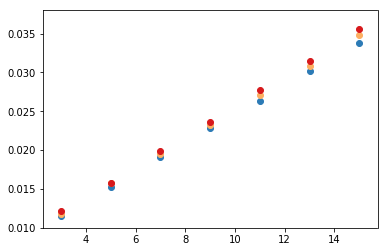

In [278]:
plt.scatter(o_ng['dT'],o_ng['wc']['f_cow'][0,:],c="#2c7bb6")
plt.scatter(o_ng['dT'],o_ng['wc']['f_cow'][1,:],c="#fdae61")
plt.scatter(o_ng['dT'],o_ng['wc']['f_cow'][2,:],c="#d7191c")

plt.ylim(0.01, 0.038)